# 1) Business Understanding

### 1) Project Overview

The project data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

The data consists of three datasets:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


### 2) Project Goal

The goal of the data analysis of the Starbucks rewards mobile app is:

* to find out which offer works best
* to find out which customers should be targeted
* build a model that predicts whether a offer will be completed or not


### 3) Metrics

As I am  using supervised learning for my classification problem, I decided to use accuracy and the F1 score as metrics to compare my models. With accuracy I am measuring how many offers my model classified correctly and with the F1 score I am considering precision as well as recall for my model.

# 2) Data Understanding

In [428]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import make_scorer
%matplotlib inline

In [429]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [430]:
# taking a look at the data first
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [431]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [432]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [433]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [434]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [435]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# 3) Data preparation/Wrangling

### 3.1) Portfolio

- Split channels into different columns
- Rename id to make clear that it's offer_id

In [436]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


##### Split channels

In [437]:
# split channel names - first get channels
channels = set()

for c in portfolio['channels']:
    channels.update(set(c))
    
channels

{'email', 'mobile', 'social', 'web'}

In [438]:
# add channels to portfolio datatable
for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

In [439]:
# drop channels column
portfolio.drop('channels',axis=1, inplace=True)

##### Rename column

In [440]:
# rename id 
portfolio = portfolio.rename(columns={"id": "offer_id"})

In [441]:
#checking for NaNs
portfolio.isnull().sum()

difficulty    0
duration      0
offer_id      0
offer_type    0
reward        0
mobile        0
email         0
social        0
web           0
dtype: int64

### 3.2) Profile

- Fix Age with outliers (e.g. 118)
- Deal with missing values in gender column
- Deal with missing values in income column
- Convert became_member_on to datetime and extract year and month
- Rename id

In [442]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [443]:
#check for missing values first
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

##### Age outliers

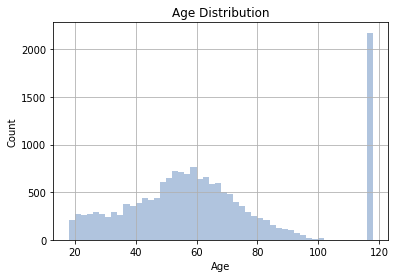

In [444]:
# check age distribution
profile.age.hist(bins=50,color='lightsteelblue');
plt.xlabel ('Age');
plt.ylabel ('Count');
plt.title('Age Distribution');

In [445]:
# check data for outlier 118
profile[profile['age']==118]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [446]:
# After analysing the outliers age = 118, i found out that these outliers are also the  2175 missing values 
# for gender and income. As I don't want to fill all rows with income.mean and age.mean and define gender
# as U, I decided to drop these rows. For me it seems like there might be a mistake in data processing.

profile = profile[profile.age != 118]

In [447]:
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

No missing values in gender and income column left

##### Convert became_member_on

In [448]:
# convert to datetime and extract year an month
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_year'] = profile.became_member_on.dt.year
profile['became_member_month'] = profile.became_member_on.dt.month

In [449]:
profile.head()

,age,became_member_on,gender,id,income,became_member_year,became_member_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11


##### Rename id

In [450]:
# rename id 
profile = profile.rename(columns={"id": "customer_id"})

In [451]:
# check for duplicates before moving on
profile.duplicated().sum()

0

### Transcript

- Rename person to customer_id
- Split value column

In [452]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [453]:
# check NAs
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

##### Rename person column

In [454]:
# rename id 
transcript = transcript.rename(columns={"person": "customer_id"})

##### Split value column

In [455]:
# split value dictionary
transcript['event_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) 
transcript['id_or_amount'] = transcript['value'].apply(lambda x: list(x.values())[0]) 

In [456]:
# drop value column
transcript.drop('value',axis=1, inplace=True)

In [457]:
transcript.head()

,event,customer_id,time,event_type,id_or_amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [458]:
# check missing values before moving on
transcript.isnull().sum()

event           0
customer_id     0
time            0
event_type      0
id_or_amount    0
dtype: int64

In [459]:
# check duplicates - in this dataset it is fine to have duplicates
transcript.duplicated().sum()

397

# 4) Data Analysis/Modeling

### 4.1) Data Analaysis

##### What is the average age of a starbucks customer? Is there a different age distribution for men and women?

In [460]:
profile['age'].mean()

54.39352445193929

In [461]:
# group age into four groups:
profile['age_groups'] = pd.cut(profile.age, bins=[0, 20, 40, 60, 80, 150], 
                               labels=['under_20', '20to40', '40to60', '60to80', 'over80'])

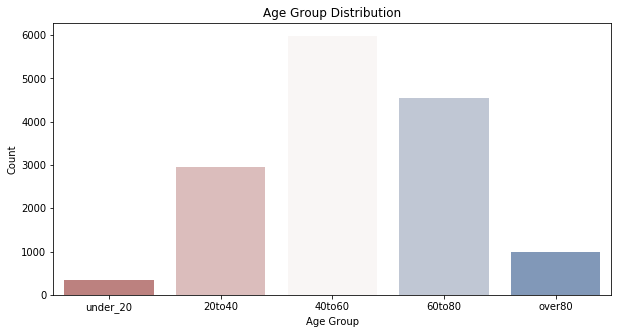

In [462]:
plt.figure(figsize=(10, 5))
sb.countplot(data = profile, x = 'age_groups',palette='vlag_r');
plt.xlabel ('Age Group');
plt.ylabel ('Count');
plt.title('Age Group Distribution');

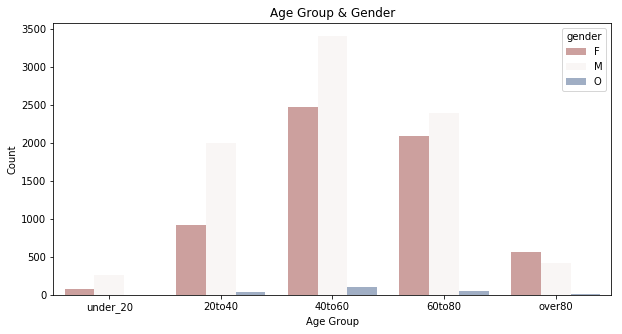

In [463]:
# plot age group per gender
plt.figure(figsize=(10, 5))
sb.countplot(data = profile, x= 'age_groups', hue = 'gender',palette='vlag_r');
plt.xlabel ('Age Group');
plt.ylabel ('Count');
plt.title('Age Group & Gender');

For men and women, the biggest age groups are 40 to 60 and 60 to 80. That's reflecting the average age of 54.4 years as well.

##### What is the average income of a starbucks customer? Is there a difference between gender?

In [464]:
profile['income'].mean()

65404.9915682968

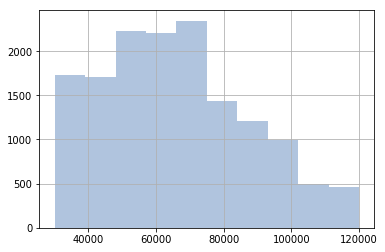

In [465]:
# check distribution of income
profile.income.hist(color='lightsteelblue');

In [466]:
# create income groups:
profile['income_groups'] = pd.qcut(profile['income'], 4, labels=["low", "medium", "medium_high", "high"])

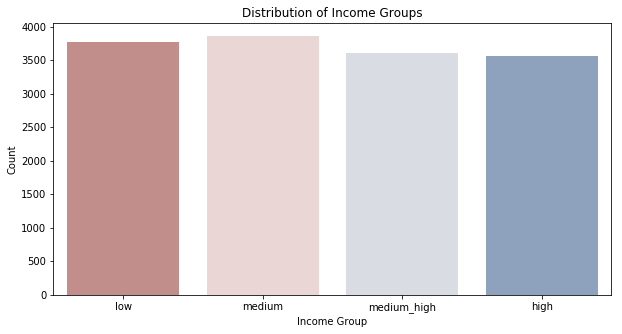

In [467]:
plt.figure(figsize=(10, 5))
sb.countplot(data = profile, x = 'income_groups',palette='vlag_r');
plt.xlabel ('Income Group');
plt.ylabel ('Count');
plt.title('Distribution of Income Groups');

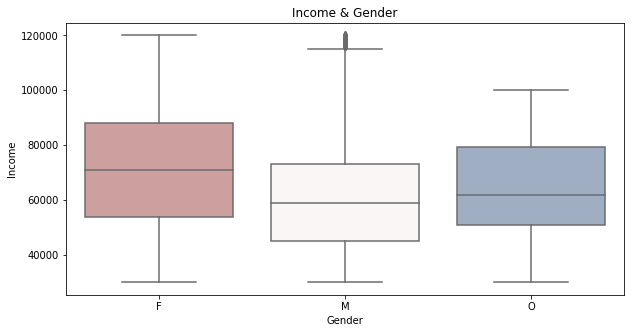

In [468]:
# plot income distribution an gender (not plotting U as income is all the same):
plt.figure(figsize=(10, 5))
sb.boxplot(data = profile, x = profile[profile['gender'] != 'U']['gender'], y='income',palette='vlag_r' )
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.title('Income & Gender');

The average income of a starbucks customer is 65.405. The average income of women is a little bit higher compared to men. 

##### In which year most people created an account? Is there a difference between men and women?

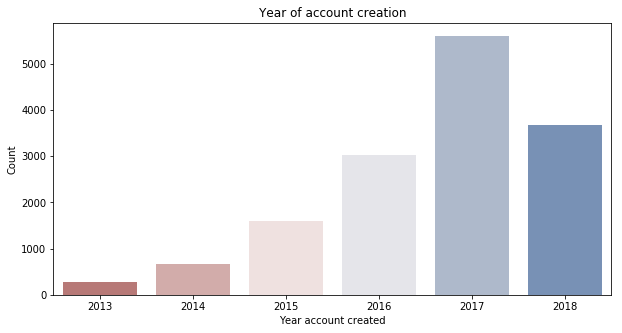

In [469]:
plt.figure(figsize=(10, 5))
sb.countplot(data = profile, x = 'became_member_year',palette='vlag_r');
plt.xlabel ('Year account created');
plt.ylabel ('Count');
plt.title('Year of account creation');

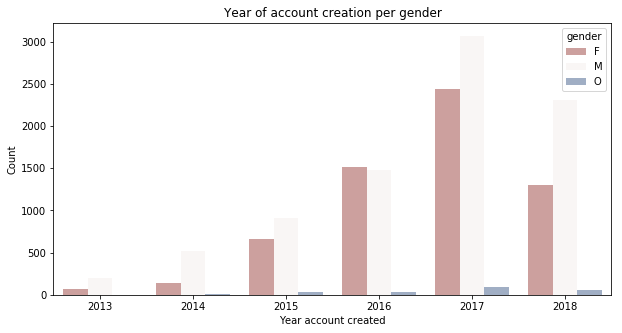

In [470]:
# plot creation year and gender
plt.figure(figsize=(10, 5))
sb.countplot(data = profile, x= 'became_member_year', hue = 'gender',palette='vlag_r');
plt.xlabel ('Year account created');
plt.ylabel ('Count');
plt.title('Year of account creation per gender');

Most people created there account in 2017 and 2018. While this is also true for male customers, most female customers created there accounts in 2017 and 2016.

##### What is the average transaction amount and what is influencing the amount of transaction?

For my analysis on transaction amounts, I decided to merge the profile and the transcript dataframe to get more information about transaction data:

In [471]:
# I use the profile table as my basis because I am interested in analyzing the behavior of the customers

combined_data = pd.merge(profile, transcript, how='left', on='customer_id')

In [472]:
combined_data.head(2)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,age_groups,income_groups,event,time,event_type,id_or_amount
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,transaction,18,amount,21.51
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,transaction,144,amount,32.28


In [473]:
# creating dataframe only containing transactions
transactions = combined_data[combined_data['event'] == 'transaction']

In [474]:
# renaming column because it only contains transaction amounts now
transactions = transactions.rename(columns={"id_or_amount": "transaction_amount"})

In [475]:
# converting transaction amount to numeric
transactions['transaction_amount']= pd.to_numeric(transactions['transaction_amount'])

In [476]:
# mean of transaction amount
transactions['transaction_amount'].mean()

13.996324531894118

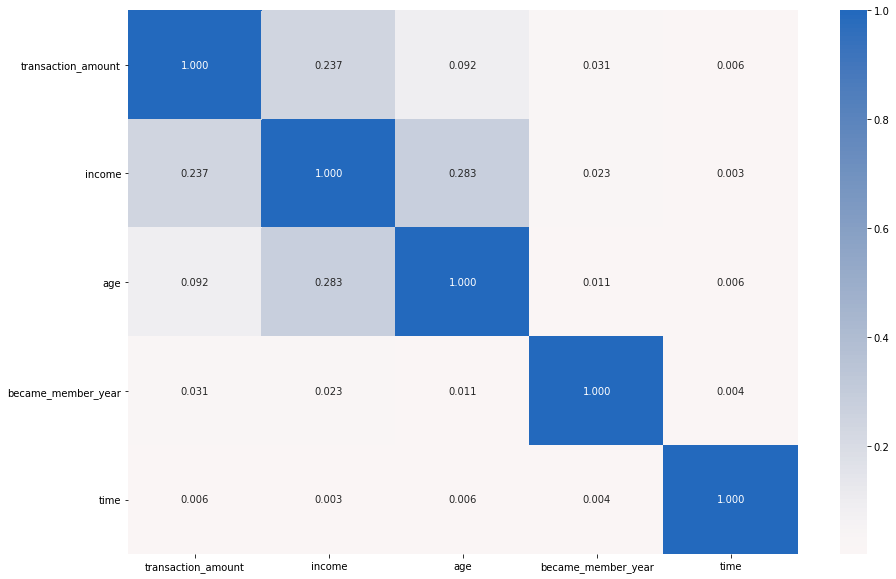

In [477]:
# checking correlation between transaction amount and numeric features
numeric_vars= ['transaction_amount','income','age','became_member_year','time']
plt.figure(figsize = [15, 10])
sb.heatmap(transactions[numeric_vars].corr(), annot = True,fmt = '.3f',
           cmap = 'vlag_r', center = 0);

Income seems to have the highest influence on the transaction amount. In the following graphs I will also visualize the influence of age and gender.

1.) Influence of income

In [478]:
# group amount into groups:
transactions['amount_groups'] = pd.cut(transactions['transaction_amount'], bins=[0, 5, 10, 20, 30, 40,50,1500], 
                               labels=['under5', '5to10', '10to20', '20to30', '30to40','40to50','over50'])

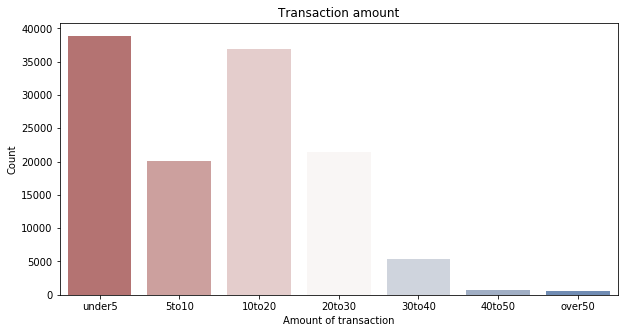

In [479]:
# and plot distribution of amount groups:
plt.figure(figsize=(10, 5))
sb.countplot(data = transactions, x = 'amount_groups',palette='vlag_r');
plt.xlabel ('Amount of transaction');
plt.ylabel ('Count');
plt.title('Transaction amount');

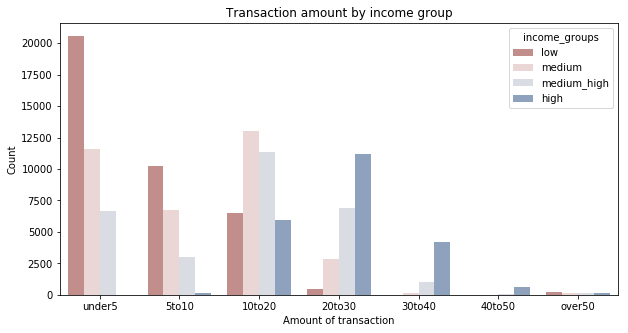

In [480]:
# first check influence of income:
plt.figure(figsize=(10, 5))
sb.countplot(data = transactions, x= 'amount_groups', hue = 'income_groups',palette='vlag_r');
plt.xlabel ('Amount of transaction');
plt.ylabel ('Count');
plt.title('Transaction amount by income group');

In [481]:
# only looking at two biggest gender groups, female and male:
transactions_fm = transactions[(transactions['gender'] == 'F') | (transactions['gender'] == 'M' )]

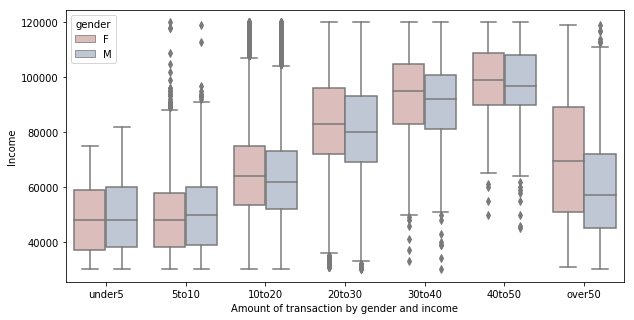

In [482]:
plt.figure(figsize=(10, 5))
sb.boxplot(data = transactions_fm, x = 'amount_groups', y='income', hue = 'gender',palette='vlag_r' )
plt.xlabel ('Amount of transaction by gender and income');
plt.ylabel('Income');

Customer with high income have the highest share within transaction amount groups from 20 to 50. Especially female customers have a higher income in higher transactions groups. Within the very small amount group over 50, the average income is lower compared to the amount groups 20 to 50.

2.) Influence of age and gender

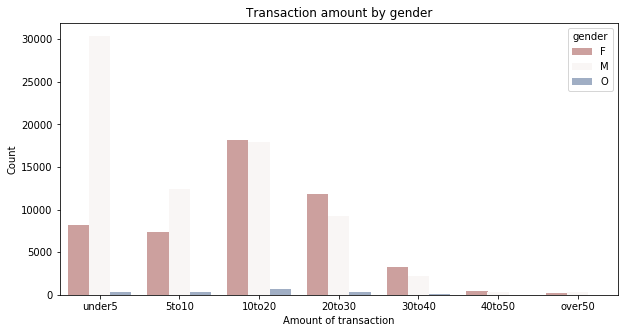

In [483]:
# plot creation transaction amount and gender
plt.figure(figsize=(10, 5))
sb.countplot(data = transactions, x= 'amount_groups', hue = 'gender',palette='vlag_r');
plt.xlabel ('Amount of transaction');
plt.ylabel ('Count');
plt.title('Transaction amount by gender');

In [484]:
# splitting dataframe into female and male customers
female = transactions[transactions['gender'] == 'F']
male = transactions[transactions['gender'] == 'M']

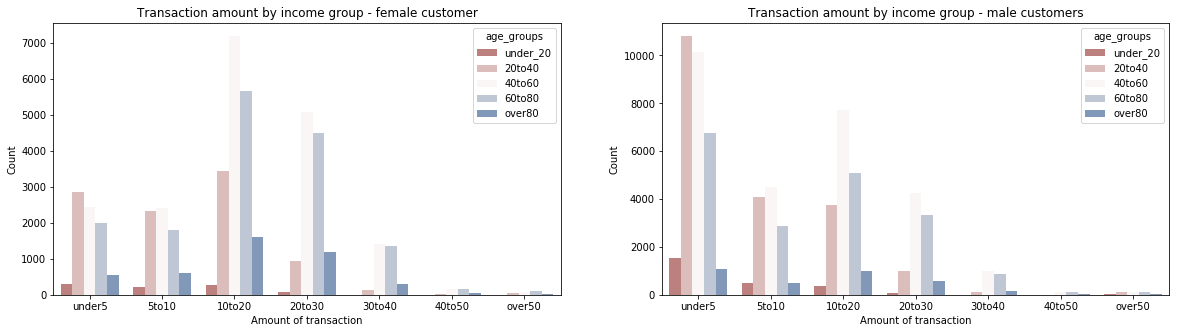

In [485]:
plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1) 
sb.countplot(data = female, x= 'amount_groups', hue = 'age_groups',palette='vlag_r');
plt.xlabel ('Amount of transaction');
plt.ylabel ('Count');
plt.title('Transaction amount by income group - female customer');

plt.subplot(1, 2, 2) 
sb.countplot(data = male, x= 'amount_groups', hue = 'age_groups',palette='vlag_r');
plt.xlabel ('Amount of transaction');
plt.ylabel ('Count');
plt.title('Transaction amount by income group - male customers');

Female customers between 40 and 80 years old are spending the most money. Male customers between 20 and 40 are spending the least money. 

##### Which offer types are most attractive? Is there a diference between gender or age?

For my further analysis, I decided to create and dataframe called offers that only contained offers and merge this dataframe with the portfolio dataframe, to get more information about the offers. 

In [486]:
# only using events equal offer
offers = combined_data[combined_data['event'] != 'transaction']

In [487]:
# renaming column because it only contains offer ids now
offers = offers.rename(columns={"id_or_amount": "offer_id"})

In [488]:
# merge offer table with portfolio table to get more information about offer
offers = pd.merge(offers, portfolio, how='left', on='offer_id')

In [489]:
offers.head(2)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,age_groups,income_groups,event,...,event_type,offer_id,difficulty,duration,offer_type,reward,mobile,email,social,web
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,offer received,...,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,offer received,...,offer id,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1


In [490]:
# check for duplicates:
offers.duplicated().sum()

374

In [491]:
# remove duplicates:
offers.drop_duplicates(inplace=True)

As I am interested in the completion of an offer, I implemented to dataframes: 
- dataframe with offers received (without informational offers)
- dataframe with offers completed

In [492]:
# encode event column to offer successful or not (successful = offer completed)
offers['offer_successful'] = offers['event'].apply(lambda x: 1 if x == 'offer completed' else 0)

In [493]:
#  implementing offer_completed dataframe
offers_completed = offers[offers['event'] == 'offer completed']

In [494]:
# implementing offers_received dataframe without informational
offers_received = offers[offers['offer_type'] != 'informational']
offers_received = offers_received[offers_received['event'] == 'offer received']

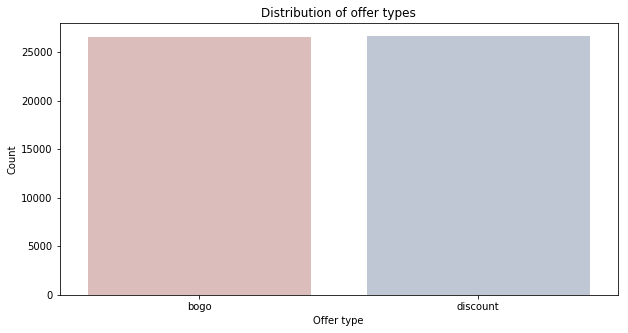

In [495]:
# looking at distribution of offer types
plt.figure(figsize=(10, 5))
sb.countplot(data = offers_received, x = 'offer_type',palette='vlag_r');
plt.xlabel ('Offer type');
plt.ylabel ('Count');
plt.title('Distribution of offer types');

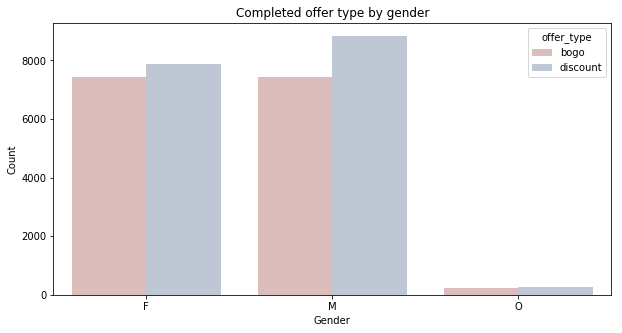

In [496]:
# plotcompleted offers by type and gender
plt.figure(figsize=(10, 5))
sb.countplot(data = offers_completed, x= 'gender', hue = 'offer_type',palette='vlag_r');
plt.xlabel ('Gender');
plt.ylabel ('Count');
plt.title('Completed offer type by gender');

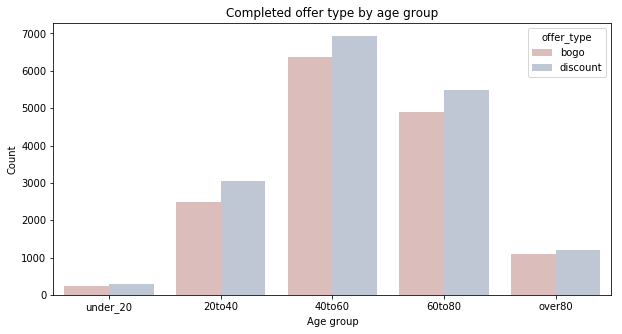

In [497]:
# plot completed offers by type and age group
plt.figure(figsize=(10, 5))
sb.countplot(data = offers_completed, x= 'age_groups', hue = 'offer_type',palette='vlag_r');
plt.xlabel ('Age group');
plt.ylabel ('Count');
plt.title('Completed offer type by age group');

The most popular offer type is discount, although buy one get one free and discount have the same received offer count.

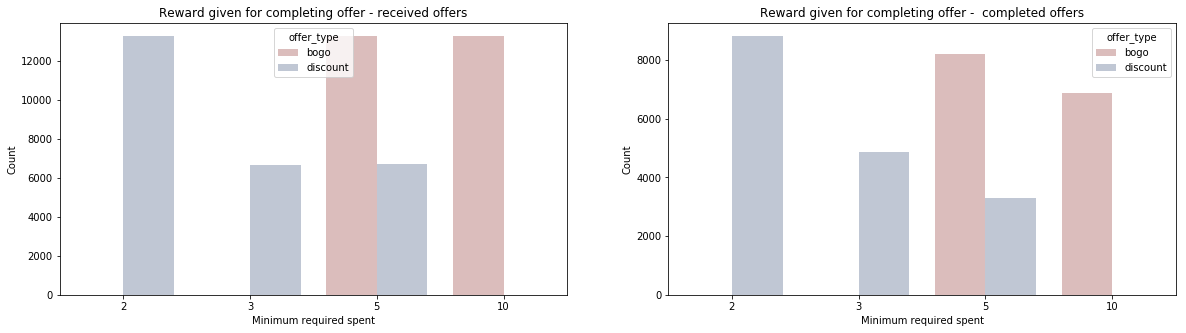

In [498]:
plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1) 
sb.countplot(data = offers_received, x= 'reward', hue = 'offer_type', palette='vlag_r');
plt.xlabel ('Minimum required spent');
plt.ylabel ('Count');
plt.title('Reward given for completing offer - received offers');

plt.subplot(1, 2, 2)  
sb.countplot(data = offers_completed, x= 'reward', hue = 'offer_type',palette='vlag_r');
plt.xlabel ('Minimum required spent');
plt.ylabel ('Count');
plt.title('Reward given for completing offer -  completed offers');

Offers with a higher minimium required spent are less attractive.

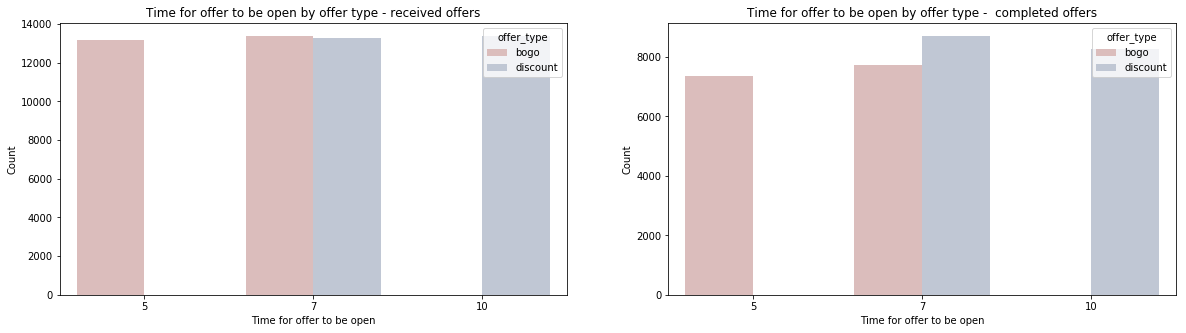

In [499]:
plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1) 
sb.countplot(data = offers_received, x= 'duration', hue = 'offer_type',palette='vlag_r');
plt.xlabel ('Time for offer to be open');
plt.ylabel ('Count');
plt.title('Time for offer to be open by offer type - received offers');

plt.subplot(1, 2, 2)  
sb.countplot(data = offers_completed, x= 'duration', hue = 'offer_type',palette='vlag_r');
plt.xlabel ('Time for offer to be open');
plt.ylabel ('Count');
plt.title('Time for offer to be open by offer type -  completed offers');

##### Which offer has the highest success rate?

In [500]:
# calculating successful offers by offer id
successful = offers_completed[['offer_id','offer_successful']].groupby('offer_id').count().reset_index()

In [501]:
# calculating total offers (= offers received) by offer id
received = offers_received[['offer_id','event']].groupby('offer_id').count().reset_index()

In [502]:
# merging both dataframes and calculating success rate
offer_id = pd.merge(received, successful, how='left', on='offer_id')
offer_id['success_rate']=offer_id['offer_successful']/offer_id['event']
offer_id.sort_values(by=['success_rate'],ascending=False)

,offer_id,event,offer_successful,success_rate
7,fafdcd668e3743c1bb461111dcafc2a4,6652,4957,0.745189
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4847,0.728325
6,f19421c1d4aa40978ebb69ca19b0e20d,6576,4074,0.619526
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,4141,0.619447
2,2906b810c7d4411798c6938adc9daaa5,6631,3860,0.582114
5,ae264e3637204a6fb9bb56bc8210ddfd,6683,3604,0.539279
3,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3281,0.497649
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3306,0.491525


In [503]:
# getting information from portfolio dataframe
offer_id = pd.merge(offer_id, portfolio, how='left', on='offer_id')

In [504]:
# droping columns I don't want to show as result
offer_id.drop(['offer_id','event','offer_successful','social','mobile','web','email'],axis=1, inplace=True)
offer_id = offer_id.rename(columns={"success_rate": "Success rate","difficulty":"Minimum spent",
                                    "duration":"Duration","offer_type":"Offer type","reward":"Reward"})
offer_id.sort_values(by=['Success rate'],ascending=False)

,Success rate,Minimum spent,Duration,Offer type,Reward
7,0.745189,10,10,discount,2
1,0.728325,7,7,discount,3
6,0.619526,5,5,bogo,5
4,0.619447,5,7,bogo,5
2,0.582114,10,7,discount,2
5,0.539279,10,7,bogo,10
3,0.497649,10,5,bogo,10
0,0.491525,20,10,discount,5


The offers with the highest success rate are: 
- dicount with a minimum spent 10/reward of 2/duration 10
- discount with a minimum spent of 7/reward 3/duration 7

### 4.2) Data Modeling

##### Building model to predict if offer is getting completed

For my model, I want to use all completed offers and all offers that are not completed. As my offers_received dataframe still contains offers that were completed, I am filtering out all received offers that have been completed.

In [505]:
# creating a new column customer_id + offer_id, to filter out offers that were completed from the offers_received dataframe:

offers_completed = offers_completed.copy()
offers_completed['new_id']= offers_completed['customer_id']+offers_completed['offer_id']

In [506]:
offers_completed.head(2)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,age_groups,income_groups,event,...,difficulty,duration,offer_type,reward,mobile,email,social,web,offer_successful,new_id
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,offer completed,...,5,7,bogo,5,1,1,0,1,1,0610b486422d4921ae7d2bf64640c50b9b98b8c7a33c4b...
5,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,60to80,high,offer completed,...,5,7,bogo,5,1,1,0,1,1,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...


In [507]:
# creating same column in offers_received
offers_received['new_id']= offers_received['customer_id']+offers_received['offer_id']

In [508]:
offers_received.head(2)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,age_groups,income_groups,event,...,difficulty,duration,offer_type,reward,mobile,email,social,web,offer_successful,new_id
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,offer received,...,5,7,bogo,5,1,1,0,1,0,0610b486422d4921ae7d2bf64640c50b9b98b8c7a33c4b...
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,60to80,high,offer received,...,5,7,bogo,5,1,1,0,1,0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...


In [509]:
# creating column that shows which rows should be deleted
ids = offers_completed['new_id'].tolist()
offers_received.loc[offers_received['new_id'].isin(ids), 'delete'] = 'delete'

In [510]:
offers_received.head(2)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,age_groups,income_groups,event,...,duration,offer_type,reward,mobile,email,social,web,offer_successful,new_id,delete
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,40to60,high,offer received,...,7,bogo,5,1,1,0,1,0,0610b486422d4921ae7d2bf64640c50b9b98b8c7a33c4b...,delete
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,60to80,high,offer received,...,7,bogo,5,1,1,0,1,0,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,delete


In [511]:
# creating dataframe with not completed offers
offers_not_completed = offers_received[offers_received.delete != 'delete']
offers_not_completed = offers_not_completed.copy()

In [512]:
# deleting column as it's not needed anymore
offers_not_completed.drop('delete',axis=1, inplace=True)

In [532]:
# creating dataframe for data model
model_data = pd.concat([offers_not_completed,offers_completed])

In [533]:
model_data.shape

(50654, 23)

In [534]:
model_data['offer_successful'].value_counts()

1    32070
0    18584
Name: offer_successful, dtype: int64

In [535]:
# drop columns I don't want to use for my model:

model_data.drop(['became_member_on','became_member_month','customer_id','event','age_groups','income_groups','event','event_type','time','offer_id','new_id'],axis=1, inplace=True)

In [536]:
model_data.head(5)

,age,gender,income,became_member_year,difficulty,duration,offer_type,reward,mobile,email,social,web,offer_successful
14,68,M,70000.0,2018,10,7,discount,2,1,1,0,1,0
41,58,M,51000.0,2017,7,7,discount,3,1,1,1,1,0
46,61,F,57000.0,2017,20,10,discount,5,0,1,0,1,0
60,26,M,46000.0,2014,10,7,discount,2,1,1,0,1,0
62,26,M,46000.0,2014,10,7,bogo,10,1,1,1,0,0


Normalizing numerical features

In [537]:
# normalize each numerical feature
scaler = MinMaxScaler()
numerical = ['age', 'income', 'difficulty', 'duration', 'reward']

model_data[numerical] = scaler.fit_transform(model_data[numerical])

model_data.head()

,age,gender,income,became_member_year,difficulty,duration,offer_type,reward,mobile,email,social,web,offer_successful
14,0.602410,M,0.444444,2018,0.333333,0.4,discount,0.000,1,1,0,1,0
41,0.481928,M,0.233333,2017,0.133333,0.4,discount,0.125,1,1,1,1,0
46,0.518072,F,0.300000,2017,1.000000,1.0,discount,0.375,0,1,0,1,0
60,0.096386,M,0.177778,2014,0.333333,0.4,discount,0.000,1,1,0,1,0
62,0.096386,M,0.177778,2014,0.333333,0.4,bogo,1.000,1,1,1,0,0


Converting categorical data

In [538]:
# converting categorical data with one hot encoding
model_data = pd.get_dummies(model_data, columns=['gender','became_member_year','offer_type'])

In [539]:
model_data.head(2)

,age,income,difficulty,duration,reward,mobile,email,social,web,offer_successful,...,gender_M,gender_O,became_member_year_2013,became_member_year_2014,became_member_year_2015,became_member_year_2016,became_member_year_2017,became_member_year_2018,offer_type_bogo,offer_type_discount
14,0.602410,0.444444,0.333333,0.4,0.000,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,1
41,0.481928,0.233333,0.133333,0.4,0.125,1,1,1,1,0,...,1,0,0,0,0,0,1,0,0,1


Spliting data 

In [521]:
# spliting data into training and testing set

y = model_data['offer_successful']
X = model_data.loc[:, model_data.columns != 'offer_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 40523 samples.
Testing set has 10131 samples.


##### Decision Tree

In [522]:
# build a classifier
clf_dt = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 5)

# Fit the model on the training data
clf_dt.fit(X_train, y_train)

# Make predictions on the test data
dt_preds = clf_dt.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, dt_preds)
F1_score = f1_score(y_test,dt_preds)

print('The accuracy score is', accuracy)
print('The F1 score is', F1_score)

The accuracy score is 0.7226335011351298
The F1 score is 0.7870889528716473


##### Random Forrest

In [523]:
# build a classifier
clf_rf = RandomForestClassifier(n_estimators= 10, max_depth= 10,random_state= 42,min_samples_leaf=5)

# Fit the model on the training data
clf_rf.fit(X_train, y_train)

# Make predictions on the test data
rf_preds = clf_rf.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, rf_preds)
F1_score = f1_score(y_test,rf_preds)

print('The accuracy score is', accuracy)
print('The F1 score is', F1_score)

The accuracy score is 0.739413680781759
The F1 score is 0.8041252411336993


##### Ada Boost

In [524]:
# build a classifier for ada boost
clf_ada = AdaBoostClassifier()

# Fit the model on the training data
clf_ada.fit(X_train, y_train)

# Make predictions on the test data
ada_preds = clf_ada.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, ada_preds)
F1_score = f1_score(y_test,ada_preds)

print('The accuracy score is', accuracy)
print('The F1 score is', F1_score)

The accuracy score is 0.7288520382982924
The F1 score is 0.7989166239660347


##### Naive Bayes

In [525]:
# build a classifier for Naive Bayes
clf_nb = GaussianNB()

# Fit the model on the training data
clf_nb.fit(X_train, y_train)

# Make predictions on the test data
nb_preds = clf_nb.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, nb_preds)
F1_score = f1_score(y_test,nb_preds)

print('The accuracy score is', accuracy)
print('The F1 score is', F1_score)

The accuracy score is 0.6879873655117955
The F1 score is 0.7370435071957407


##### Choosing the best model

Based on the accuracy score and the F1 score I am choosing the Random Forrest model as the best model. As a next step I am using grid search to improve this model.

##### Improving the model

In [530]:
clf = RandomForestClassifier()

# Create the parameters list
parameters = {"max_depth": [10,20,50],
              "n_estimators": [10,100,150],
              "min_samples_split": [2,6,10],
              "min_samples_leaf": [5,8,10]}

# Make an fbeta_score scoring object
scorer = make_scorer(f1_score)

# Perform grid search on the classifier 
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator.
best_clf = grid_fit.best_estimator_

# Fit the new model.
best_clf.fit(X_train, y_train)

# Make predictions using the new model

best_preds = best_clf.predict(X_test)

# Calculate accuracy and F1 score
best_accuracy = accuracy_score(y_test, best_preds)
best_F1_score = f1_score(y_test,best_preds)

print('The accuracy score is', best_accuracy)
print('The F1 score is', best_F1_score)

The accuracy score is 0.7422761820155956
The F1 score is 0.80729205107388


The accuracy score slightly improved to 0,7423 and F1 score increased slightly to 0.8073.

In [531]:
# having a look at best estimator
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

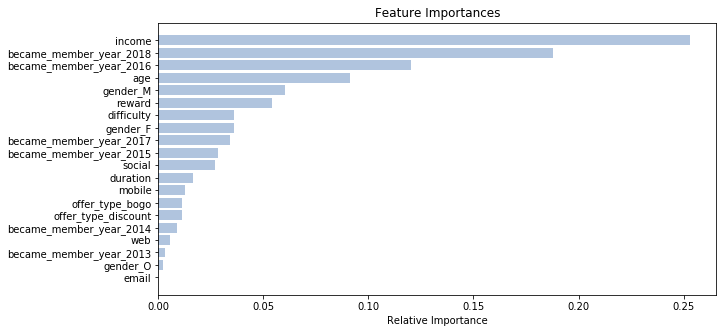

In [540]:
# looking at importance of features

model_data = model_data.columns[[0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20]]
importances = best_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightsteelblue', align='center')
plt.yticks(range(len(indices)), model_data[indices])
plt.xlabel('Relative Importance');

# 5) Conclusion

The goal of my analysis was to find out which offer works best and which people starbucks should target in their mobile app. 

#### 1.) Which offer works best?

Looking at the success rates, the top 3 offers are: 
1. Discount with a minimum spent of 10, a reward of 2 and a duration of 10 days
2. Discount with a minimum spent of 7, a reward of 3 and a duration of 7 days
3. Buy on get one free with a minimum spent of 5 and a duration of 5 days

I was not surprised, that discount offers are number one and two, because I’ve already seen in my visualizations that they are more popular than bogo. What surprised me, is that an offer with minimum spent of 10 is number one, as I’ve seen in my visualizations that offers with a higher spent tend to be less attractive.

#### 2.) Which customers should be targeted?

In my analysis I focused on the transaction amount, a customer is spending, to define if they are attractive to target. As a result of my visual, I can see that income and age play the most important roles. When looking at the transaction amount, female customers have a higher share in high transaction amount groups. Especially women between 40 and 80 years old are spending the most money in their transactions.
Not surprisingly, customers with high income have the highest share within the higher transaction amount groups from 20 to 50. Especially female customers have a higher income in these higher transactions groups. Following this, the most attractive customers to target, are women between 40 and 80 years old with an high income.

When implementing the model to predict if an offer will be completed, the feature importance graph showed, that the year a customer became member is also a very important factor. That was surprising to me, because I haven't look at this factor in the previous analysis part.

# 6) Improvements

To even better target customers, one improvement could be to integrate more data such as location, time of day offer completed, starbucks branch etc.
A next step could also be to cluster customers into different groups, analyze which offers they like most and tailor special offers for certain customer groups. 

# 7) Challenges

Challenges I faced during the implementation of my model, was the creation of the dataframe offers_not_completed. I wanted to create a dataframe that contains only received but not completed offers. The problem was that also completed offers had a row containing the event 'offer received'. By combing customer_id and offer_id, I was able to filter out these rows. 
After I solved this problem, it was definitely exciting to the how well my model performed predicting the completion of an offer.